In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

2024-05-11 14:17:02.092113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 14:17:02.092161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 14:17:02.093582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Pix2Pix GAN to generate maps from satellite imagery 

#### In this project, we explore the power of Generative Adversarial Networks (GANs) to perform image-to-image translation, a task often referred to as "Pix2Pix." GANs have revolutionized the field of computer vision and image processing by enabling us to generate realistic images from input data. Pix2Pix, a specific GAN variant, excels at transforming images from one domain to another, making it an exciting tool for various applications.

#### Image-to-image translation is a fascinating challenge in the realm of computer vision. It involves converting an image from one style, domain, or representation to another. For instance, we can transform black-and-white sketches into colorful images, turn satellite images into maps, or change summer photos into winter scenes. Pix2Pix GANs have shown remarkable capabilities in solving these problems by learning the mapping between input and output domains.
![download.png](attachment:da44c4d5-ccce-4054-b540-4f22122a3487.png)

#### Pix2Pix consists of two neural networks: a generator and a discriminator. The generator takes an input image from one domain and tries to produce an output image in the desired target domain. Simultaneously, the discriminator evaluates whether the generated image is realistic or not. Through adversarial training, the generator learns to improve its output, making it increasingly difficult for the discriminator to distinguish between real and generated images.
![download.png](attachment:a98b3122-c7d0-469b-9d93-9f9e6f881539.png)

/bin/bash: -c: line 0: syntax error near unexpected token `attachment:da44c4d5-ccce-4054-b540-4f22122a3487.png'
/bin/bash: -c: line 0: `[download.png](attachment:da44c4d5-ccce-4054-b540-4f22122a3487.png)'
/bin/bash: -c: line 0: syntax error near unexpected token `attachment:a98b3122-c7d0-469b-9d93-9f9e6f881539.png'
/bin/bash: -c: line 0: `[download.png](attachment:a98b3122-c7d0-469b-9d93-9f9e6f881539.png)'


In [3]:
path = "../input/deepglobe-road-extraction-dataset/train/"
num_images = 1000

combined_images = sorted(glob(path + "*.jpg"))[:num_images]
    
images = np.zeros(shape=(len(combined_images), 256, 256, 3))

for idx, path in enumerate(combined_images):
    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    image = combined_image 
    images[idx] = (tf.image.resize(image,(256,256)))/255

In [4]:
path = "../input/deepglobe-road-extraction-dataset/train/"
num_images = 1000

combined_images = sorted(glob(path + "*.png"))[:num_images]
    
masks = np.zeros(shape=(len(combined_images), 256, 256, 3))

for idx, path in enumerate(combined_images):
    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    mask = combined_image 
    masks[idx] = (tf.image.resize(mask,(256,256)))/255

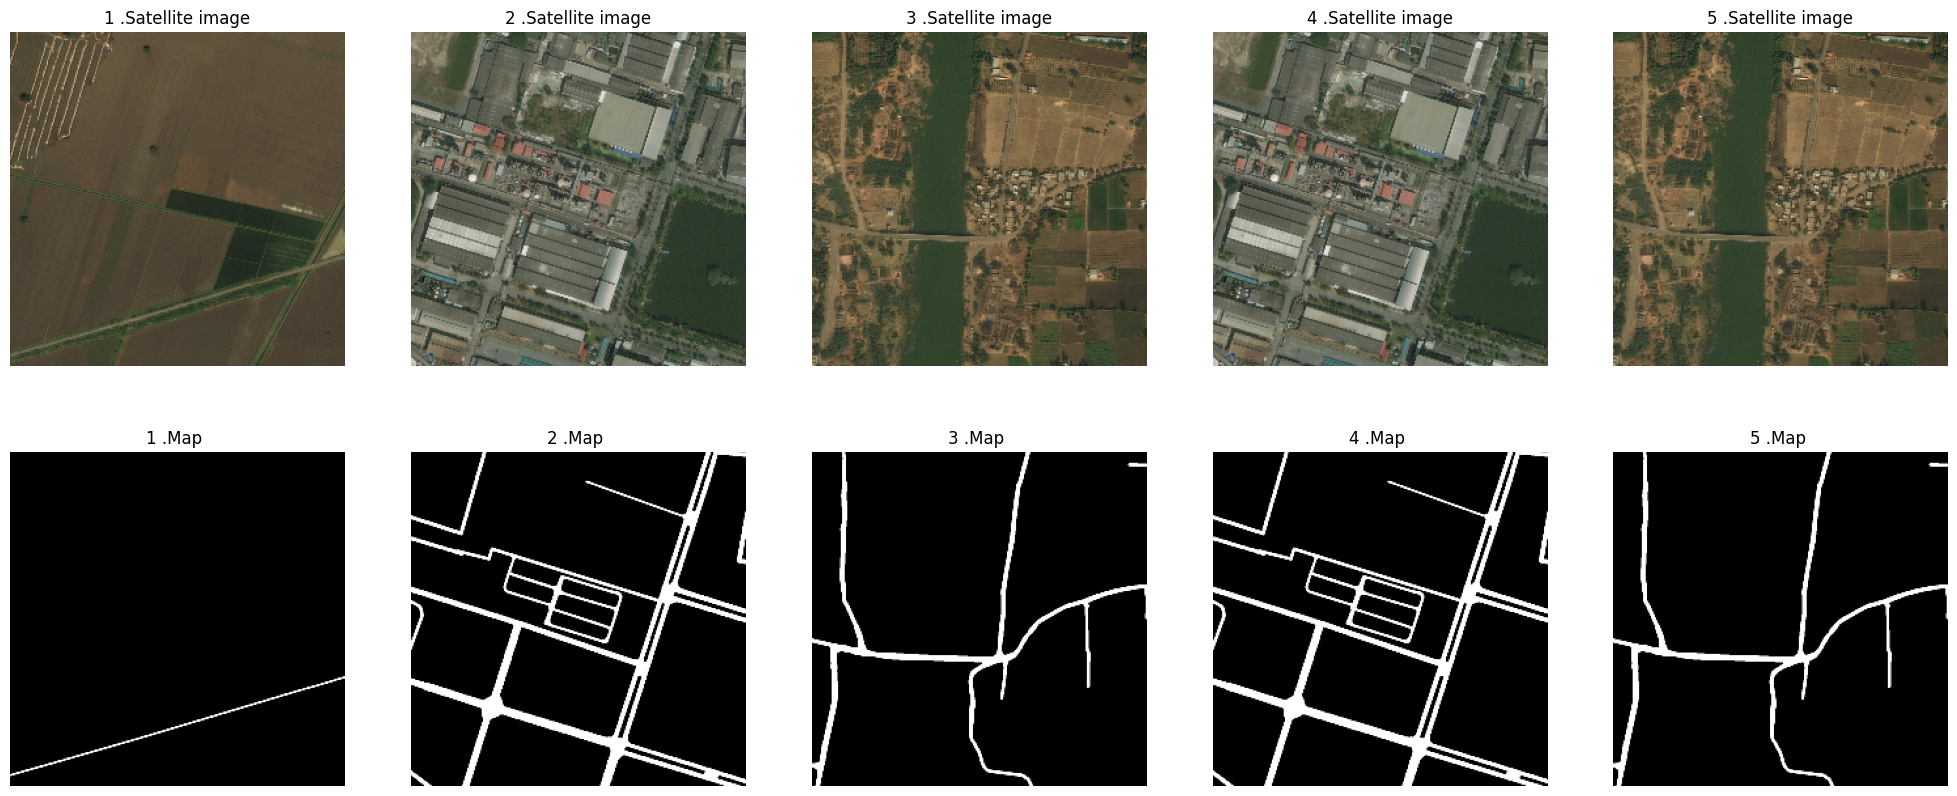

In [5]:
plt.figure(figsize=(25,10))
for i in range(1,6):
    idx = np.random.randint(1,10)
    image, mask = images[idx], masks[idx]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(str(i) + " .Satellite image")
    plt.axis("off")
    
    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title(str(i) + " .Map ")
    plt.axis("off")
plt.show()

In [6]:
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def Generator():
    inputs = Input(shape=(256,256,3), name="InputLayer")

    encoder = [
        downscale(64),
        downscale(128),
        downscale(256),
        downscale(512),
        downscale(1024),
        downscale(1024),
    ]
    
    latent_space = downscale(1024)

    decoder = [
        upscale(1024),
        upscale(1024),
        upscale(512),
        upscale(256),
        upscale(128),
        upscale(64),
    ]
    
    x = inputs 
#     skips = []
    for layer in encoder:
        x = layer(x)
#         skips.append(x)
    
    x = latent_space(x)
    for up in decoder:
        x = up(x)

#     skips = reversed(skips)
#     for up, skip in zip(decoder, skips):
#         x = up(x)
#         x = concatenate([x, skip])
    
    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, kernel_initializer = initializer, activation = 'tanh', padding = 'same')

    outputs = outputs(x)

    generator = Model(inputs = inputs, outputs = outputs, name="Generator")
    return generator

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


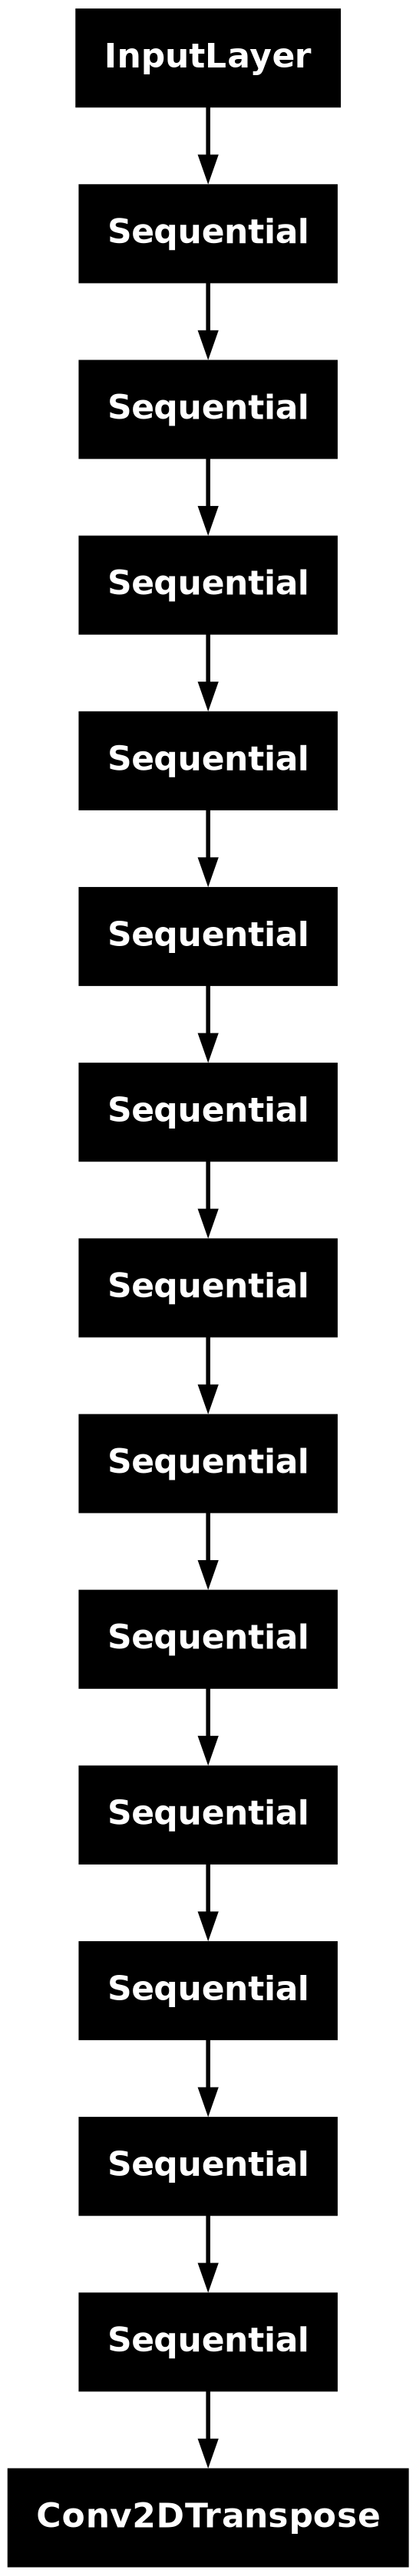

In [7]:
generator = Generator()
plot_model(generator)

In [8]:
def Discriminator():
    image = Input(shape = (256,256,3), name = "ImageInput")
    target = Input(shape = (256,256,3), name = "TargetInput")
    x = concatenate([image, target])

    x = downscale(64)(x)
    x = downscale(128)(x)
    x = downscale(512)(x)

    initializer = RandomNormal(stddev = 0.02, seed=42)
        
    x = Conv2D(512, kernel_size = 4, strides = 1, kernel_initializer = initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, kernel_size = 4, kernel_initializer = initializer)(x)

    discriminator = Model(inputs = [image, target], outputs = x, name = "Discriminator")

    return discriminator

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


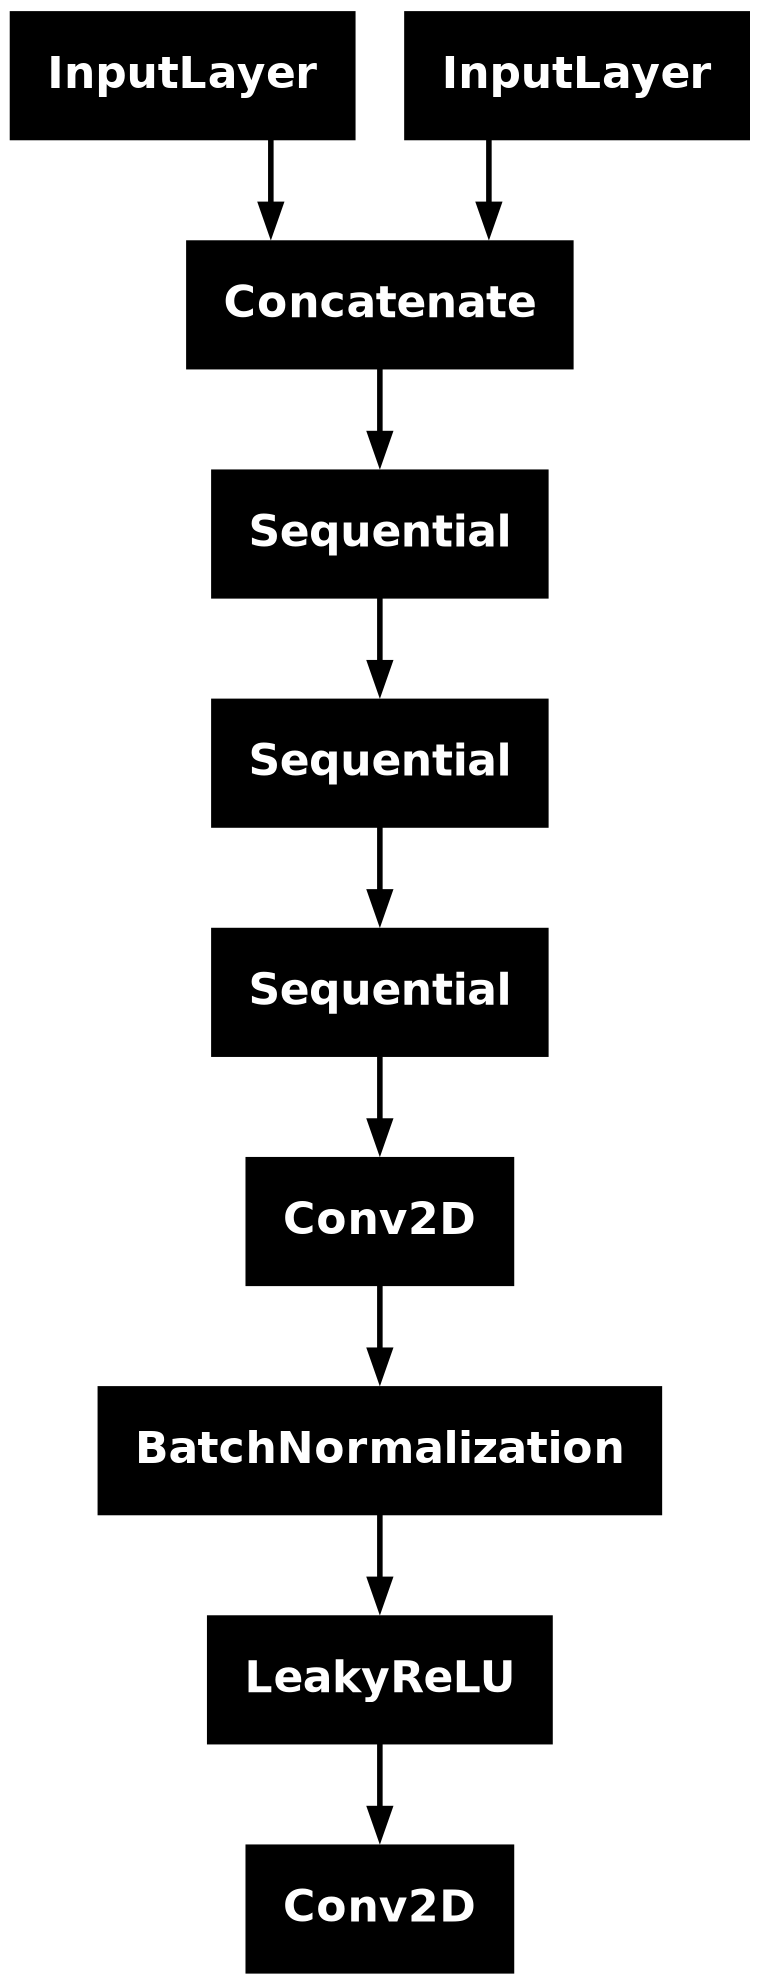

In [9]:
discriminator = Discriminator()
plot_model(discriminator)

In [10]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(discriminator_generated, generated_output, target_image):
    gan_loss = adversarial_loss(tf.ones_like(discriminator_generated), discriminator_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    total_loss = (100 * l1_loss) + gan_loss
    return total_loss, gan_loss, l1_loss

def discriminator_loss(discriminator_real_output, discriminator_generated_output):
    real_loss = adversarial_loss(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = adversarial_loss(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss
def train_step(inputs, target):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_output = generator(inputs, training=True)
        
        discriminator_real_output = discriminator([inputs, target], training=True)
        discriminator_generated_output = discriminator([inputs, generated_output], training=True)
        
        generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generated_output, target)
        
        discriminator_Loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)
        
    generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
     
    discriminator_gradients = discriminator_tape.gradient(discriminator_Loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [11]:
# def fit(data, epochs):
#   for epoch in range(epochs):
#     start = time.time()
#     print("Current epoch: ", epoch+1)
#     for image, mask in data:
#       train_step(image, mask)
#     print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")
def fit(data, epochs, verbose=1):
    for epoch in range(epochs):
        start = time.time()
        if verbose >= 1:
            print("Current epoch: ", epoch+1)
        for image, mask in data:
            train_step(image, mask)
        if verbose >= 1:
            print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")

In [12]:
sat_image, map_image = tf.cast(images, tf.float32), tf.cast(masks, tf.float32)
dataset = (sat_image, map_image)
data = tf.data.Dataset.from_tensor_slices(dataset).batch(32, drop_remainder=True)

In [13]:
fit(data, 100, verbose=2)

Current epoch:  1
Time taken to complete the epoch 1 is 44.60 seconds 

Current epoch:  2
Time taken to complete the epoch 2 is 32.39 seconds 

Current epoch:  3
Time taken to complete the epoch 3 is 32.44 seconds 

Current epoch:  4
Time taken to complete the epoch 4 is 32.40 seconds 

Current epoch:  5
Time taken to complete the epoch 5 is 32.41 seconds 

Current epoch:  6
Time taken to complete the epoch 6 is 32.42 seconds 

Current epoch:  7
Time taken to complete the epoch 7 is 32.41 seconds 

Current epoch:  8
Time taken to complete the epoch 8 is 32.42 seconds 

Current epoch:  9
Time taken to complete the epoch 9 is 32.37 seconds 

Current epoch:  10
Time taken to complete the epoch 10 is 32.39 seconds 

Current epoch:  11
Time taken to complete the epoch 11 is 32.38 seconds 

Current epoch:  12
Time taken to complete the epoch 12 is 32.34 seconds 

Current epoch:  13
Time taken to complete the epoch 13 is 32.43 seconds 

Current epoch:  14
Time taken to complete the epoch 14 i

In [14]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Satellite Image " + str(idx))
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Map Image " + str(idx))
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(idx))
        plt.axis('off')
        
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1715440395.477205     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


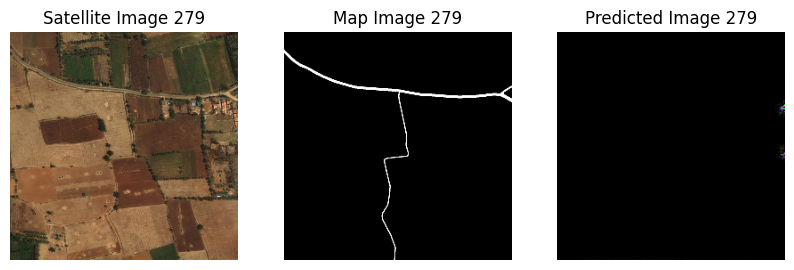

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


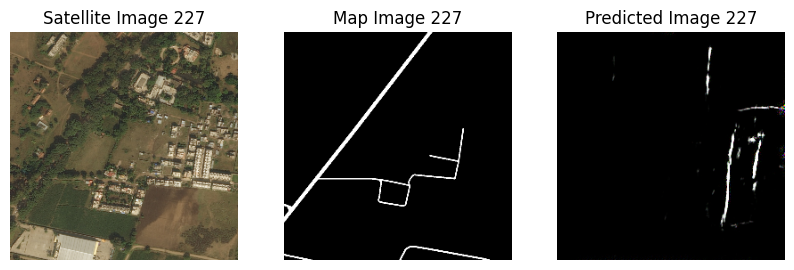

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


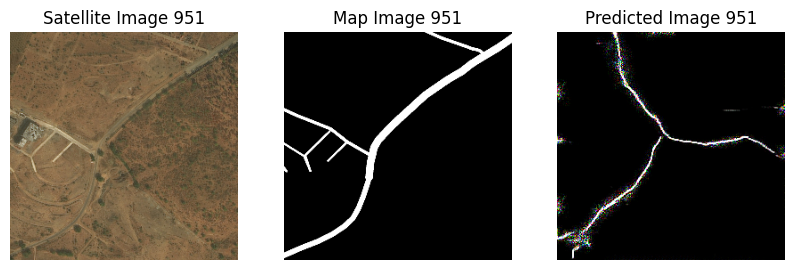

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


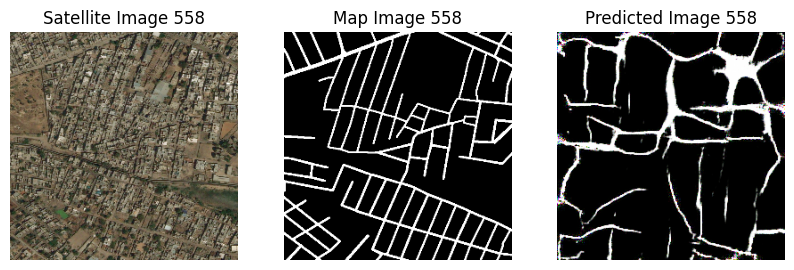

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


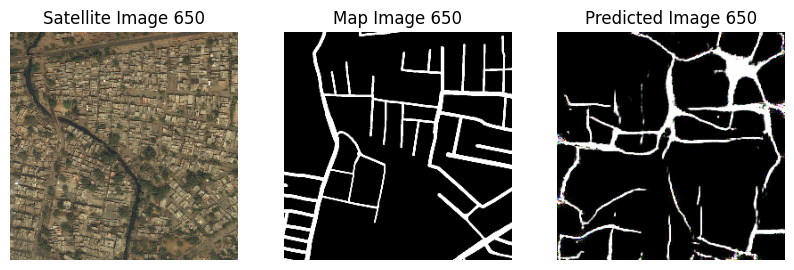

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


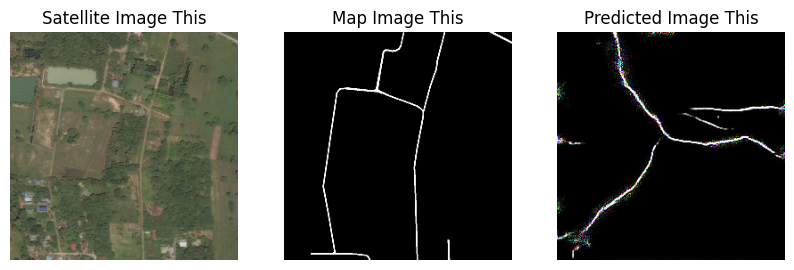

In [15]:
show_predictions(5)
image, mask = images[621], masks[621]
predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        
plt.figure(figsize=(10,8))
        
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Satellite Image " + "This")
plt.axis('off')
        
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title("Map Image " + "This")
plt.axis('off')
        
plt.subplot(1,3,3)
plt.imshow(predicted)
plt.title("Predicted Image " + "This")
plt.axis('off')
plt.show()

In [16]:
import numpy as np
import math

def calculate_metrics(images, masks, generator, num_samples):
    mse_scores = []
    mae_scores = []

    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(np.expand_dims(image, axis=0))[0]
        
        # Calculate MSE
        mse_score = np.mean((mask - predicted) ** 2)
        mse_scores.append(mse_score)
        
        # Calculate MAE
        mae_score = np.mean(np.abs(mask - predicted))
        mae_scores.append(mae_score)
        avg_mse = np.mean(mse_scores)
        avg_mae = np.mean(mae_scores)
    
    return avg_mse, avg_mae

# Usage
num_samples = 100  # Number of samples to evaluate
avg_mse, avg_mae = calculate_metrics(images, masks, generator, num_samples)
print("Average MSE:", avg_mse * 100)
print("Average MAE:", avg_mae * 100)
print("Average RMSE:",math.sqrt(avg_mse) * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [17]:
import numpy as np
import math

def calculate_metrics(images, masks, generator, num_samples):
    mse_scores = []
    mae_scores = []

    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images[idx], masks[idx]
        predicted = generator.predict(np.expand_dims(image, axis=0))[0]
        
        # Calculate MSE
        mse_score = np.mean((mask - predicted) ** 2)
        mse_scores.append(mse_score)
        
        # Calculate MAE
        mae_score = np.mean(np.abs(mask - predicted))
        mae_scores.append(mae_score)
        avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    
    return avg_mse, avg_mae

# Usage
num_samples = 100  # Number of samples to evaluate
avg_mse, avg_mae = calculate_metrics(images, masks, generator, num_samples)
print("Average MSE:", avg_mse * 100)
print("Average MAE:", avg_mae * 100)
print("Average RMSE:",math.sqrt(avg_mse) * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [18]:
generator.save("GAN_Sat_image_2_map.h5")